In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from sklearn.preprocessing import LabelEncoder
from math import *
from sklearn.preprocessing import OneHotEncoder
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
df = pd.read_csv('home-credit-default-risk//application_train.csv')

In [5]:
#on suppr toutes les colonnes à plus de 90% de val manquante
df = df[df.columns[(df.isna().sum()/df.shape[0]) < 0.9]]

In [6]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

NAME_CONTRACT_TYPE---------------------- => ['Cash loans' 'Revolving loans']
CODE_GENDER----------------------------- => ['M' 'F' 'XNA']
FLAG_OWN_CAR---------------------------- => ['N' 'Y']
FLAG_OWN_REALTY------------------------- => ['Y' 'N']
NAME_TYPE_SUITE------------------------- => ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE------------------------ => ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE--------------------- => ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS---------------------- => ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE----------------------- => ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATI

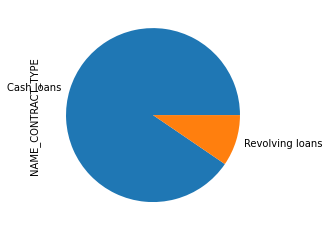

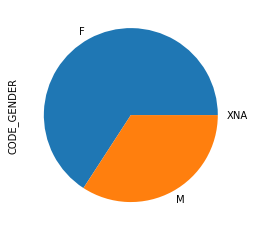

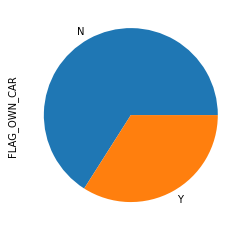

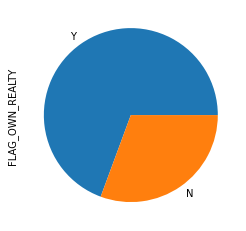

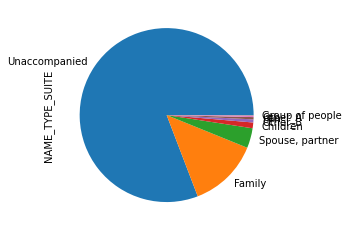

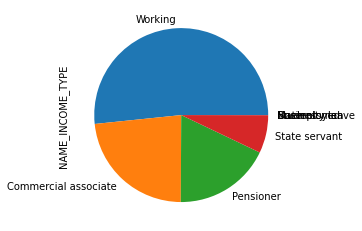

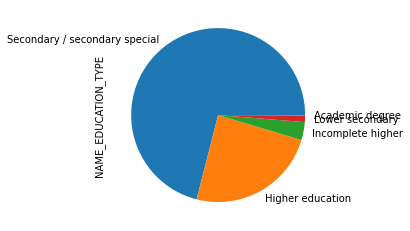

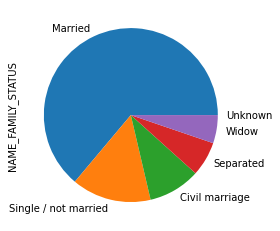

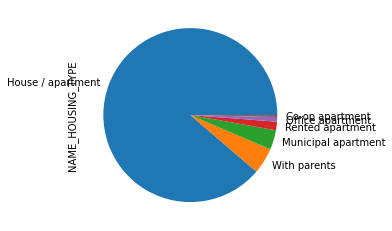

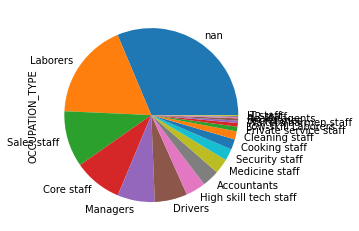

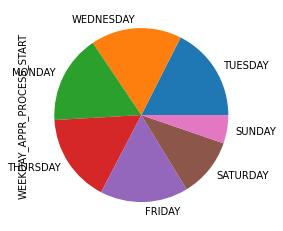

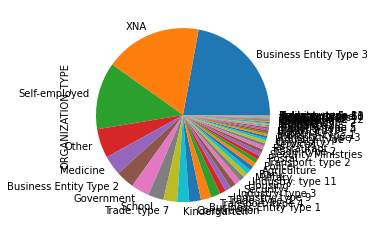

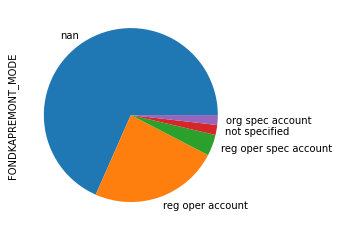

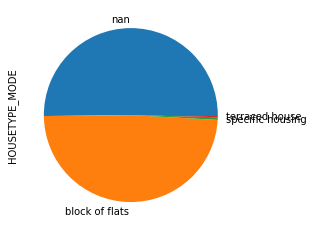

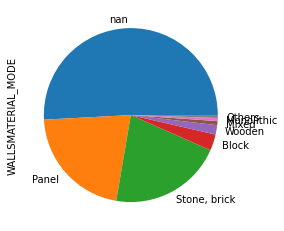

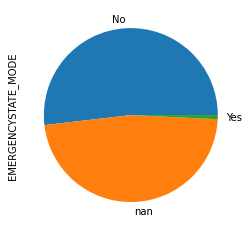

In [7]:
pbar = tqdm(total=1)
for col in df.select_dtypes('object'):
    print(f'{col :-<40} => {df[col].unique()}')
    plt.figure()
    df[col].value_counts(normalize=True, dropna=False).plot.pie()
    pbar.update(1/len(df.select_dtypes('object')))
pbar.close()

# Corelation

In [ ]:
corrMatrix = df.corr()
corrMatrix['TARGET'].sort_values(ascending=False) 

In [ ]:
corrMatrix['TARGET'].sort_values(ascending=False) >0.06

In [ ]:
corrMatrix['TARGET'].sort_values(ascending=False) <-0.06

# StratifiedShuffleSplit

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
df =  df[['TARGET','ORGANIZATION_TYPE','CODE_GENDER','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
#df = df [['TARGET','REGION_RATING_CLIENT_W_CITY','AMT_INCOME_TOTAL','OBS_30_CNT_SOCIAL_CIRCLE','FLAG_PHONE','HOUR_APPR_PROCESS_START','DAYS_REGISTRATION','FLAG_DOCUMENT_3','AMT_ANNUITY','DAYS_ID_PUBLISH','REGION_RATING_CLIENT','CNT_FAM_MEMBERS','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_LAST_PHONE_CHANGE','FLAG_WORK_PHONE','REG_CITY_NOT_WORK_CITY','AMT_GOODS_PRICE','EXT_SOURCE_1','FLAG_OWN_CAR','AMT_REQ_CREDIT_BUREAU_YEAR','EXT_SOURCE_2','EXT_SOURCE_3']]
#df = df[['ORGANIZATION_TYPE', 'ELEVATORS_AVG', 'NAME_FAMILY_STATUS', 'WALLSMATERIAL_MODE','FLAG_DOCUMENT_5', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'YEARS_BEGINEXPLUATATION_AVG', 'FLAG_DOCUMENT_17', 'WEEKDAY_APPR_PROCESS_START', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'DAYS_ID_PUBLISH', 'REGION_POPULATION_RELATIVE', 'FLAG_OWN_REALTY', 'APARTMENTS_MODE', 'FONDKAPREMONT_MODE', 'CODE_GENDER', 'BASEMENTAREA_MODE', 'NAME_CONTRACT_TYPE', 'HOUSETYPE_MODE', 'FLOORSMAX_MODE', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET', 'NAME_TYPE_SUITE']]
#df = df[['ORGANIZATION_TYPE','CODE_GENDER','FLAG_OWN_REALTY','WEEKDAY_APPR_PROCESS_START','NAME_CONTRACT_TYPE','HOUSETYPE_MODE','NAME_FAMILY_STATUS','TARGET']]

In [ ]:
df['TARGET'].hist()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(df, df['TARGET']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [ ]:
train.head()

In [ ]:
x_train = train.drop(['TARGET'], axis=1)
y_train = train['TARGET'].copy()
x_test = test.drop(['TARGET'], axis=1)
y_test = test['TARGET'].copy()

# Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

In [ ]:
pip = Pipeline([
    ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')),
    ('rsc',RobustScaler())
])

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
#num_attr = ['DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
num_attr = list(df.select_dtypes('float64'))+list(df.select_dtypes('int64'))
cat_attr = list(df.select_dtypes('object'))
num_attr.remove('TARGET')

In [ ]:
full_pipeline = ColumnTransformer([
    ('num',pip, num_attr),
    ('cat', OneHotEncoder(), cat_attr)
])

In [ ]:
for col in list(x_train.select_dtypes('object')):
    x_train[col].fillna("No College", inplace = True) 

In [ ]:
X_train = full_pipeline.fit_transform(x_train)

In [ ]:
x_train.head()

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
X = X_train

smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_sample(X, y_train)

In [ ]:
pd.Series(y_train).value_counts()


In [ ]:
X_train.shape

# Modeles

## CNN 

In [ ]:
X_train = X_train.toarray()

In [ ]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, activation='relu', input_shape=(1,X_train.shape[1])),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model10.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
history = model10.fit(X_train,
                      y_train,
                    epochs=10,
                    batch_size= 40,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10),
                               tfdocs.modeling.EpochDots(),
                               tf.keras.callbacks.ModelCheckpoint("weights.best.hdf5", 
                                                                   monitor='accuracy', 
                                                                   verbose=0, 
                                                                   save_best_only=True, 
                                                                   save_weights_only=False, 
                                                                   mode='max', 
                                                                   periode=1)])

### Courbe Apprentissage

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Sauvegarde du modele

In [ ]:
model10.save('Modeles\\model10.h5')
model10 = tf.keras.models.load_model('Modeles\\model10.h5')

### Evaluation du modele

In [ ]:
for col in list(x_test.select_dtypes('object')):
    x_test[col].fillna("No College", inplace = True) 
X_test = full_pipeline.transform(x_test)

X_test = X_test.toarray()

In [ ]:
test_loss, test_acc = model10.evaluate(X_test,y_test)

## ML

# Validation Croisée

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def display_scores(scores):
    print('scores',scores),
    print('moyenne',scores.mean())
    print('ecart type',scores.std())

# GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def display_grid(grid):
    cvr = grid.cv_results_
    for mean_score, params in zip(cvr['mean_test_score'], cvr['params']):
        print(np.sqrt(-mean_score), params)

## SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
model1 = SGDClassifier(random_state=0)

### SGDClassifier CrossVal

In [ ]:
scores = cross_val_score(model1, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model2 = DecisionTreeClassifier(max_features=7, random_state=0)

### DecisionTree CrossVal

In [ ]:
scores = cross_val_score(model2, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

### DecisionTreeClassifier GridSearchCV

In [ ]:
param_grid = {'max_features':np.arange(4,10)}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
display_grid(grid)

## KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model3 = KNeighborsClassifier(n_neighbors=8, metric='euclidean', n_jobs=-1)

### KNeighborsClassifier CrossVal

In [ ]:
scores = cross_val_score(model3, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

### KNeighborsClassifier GridSearchCV

In [ ]:
param_grid = {'n_neighbors':np.arange(7,10),
             'metric':['euclidean','manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
display_grid(grid)

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
model4 = RandomForestClassifier(n_estimators=10, max_features=5,  n_jobs=-1)

### RandomForest CrossVal

In [ ]:
scores = cross_val_score(model4, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

### RandomForestClassifier GridSearchCV

In [ ]:
param_grid = {'n_estimators':np.arange(9,11),
             'max_features':np.arange(5,6)}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
display_grid(grid)
gridRandomForest = grid

## AdaBoostClassifier

In [ ]:
model5 = AdaBoostClassifier()

### AdaBoostClassifier CrossVal

In [ ]:
scores = cross_val_score(model5, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

## GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model6 = GaussianNB()

### GaussianNB CrossVal

In [ ]:
scores = cross_val_score(model6, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

## Catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model7 = CatBoostClassifier(iterations=38, learning_rate=1, depth=2)

### CatBoost CrossVal

In [ ]:
scores = cross_val_score(model7, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rf_rmse_scores = np.sqrt(-scores)
display_scores(rf_rmse_scores)

### CatBoost GridSearchCV

In [ ]:
param_grid = {'iterations':np.arange(35,40),
             'learning_rate':np.arange(1,3)}

grid = GridSearchCV(CatBoostClassifier(), param_grid, cv=5,  scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=2)
grid.fit(X_train, y_train,verbose=False)
print(grid.best_params_)
display_grid(grid)

# votingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
#voting hard voting, soft voting
model11 = VotingClassifier([#('sgd', model1), 
                          ('tree', model2),
                          ('kn', model3),
                          ('rdforest',model4),
                          #('ada',model7),
                          #('bayes',model6)
],
                         voting='soft')

In [ ]:
#for col in list(x_test.select_dtypes('object')):
#    x_test[col].fillna("No College", inplace = True) 
#X_test = full_pipeline.transform(x_test)

In [ ]:
for model in (model1, 
              model2,
              model3, 
              model4, 
              model5, 
              model6,
              model7,
              model11):
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_test, y_test))
    print(confusion_matrix(y_test, model.predict(X_test)))
    
print('model10')
model10.fit(X_train, y_train)

## Sauvegarde des modeles

In [ ]:
import joblib

In [ ]:
for model in (model1, 
              model2,
              model3, 
              model4, 
              model5, 
              model6,
              model7,
              model11):
    joblib.dump(model, 'Modeles\\model'+model.__class__.__name__)
# loaded_model = joblib.load(filename)

## Courbes d' apprentissage

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
N, train_score, val_score = learning_curve(model4, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4, n_jobs=-1)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

# FeaturesImportances

In [ ]:
cat_attributes_feat = list(full_pipeline.transformers_[1][1].get_feature_names(full_pipeline.transformers_[1][2]))

In [ ]:
features_importances = gridRandomForest.best_estimator_.feature_importances_
attr = num_attr + cat_attr
print(attr)
sorted(zip(features_importances,  attr))

In [ ]:
attr = cat_attributes_feat + num_attr
feature = [str(columns) for columns in attr]
importance = np.round(features_importances * 100, 2)


In [ ]:
print(feature)

In [ ]:
feature_importance = pd.DataFrame({'feature' : feature, 'importance' : importance})

feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)

In [ ]:
from matplotlib.pyplot import figure
feature_importance_sorted.plot.barh(x = 'feature', y = 'importance')

In [ ]:
feature_importance_sorted[feature_importance_sorted['importance']>0]

# ModelSelection

In [ ]:
from sklearn import model_selection

In [ ]:
# Prepare an array with all the algorithms
models = []
models.append(('SGD', SGDClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GNB', GaussianNB()))

In [ ]:
# Prepare the configuration to run the test
seed = 7
results = []
names = []
X = X_train
Y = y_train

In [ ]:
# Every algorithm is tested and results are
# collected and printed
for name, model in models:
kfold = model_selection.KFold(
n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(
model, X, Y, cv=kfold, scoring='accuracy')
results.append(cv_results)
names.append(name)
msg = "%s: %f (%f)" % (
name, cv_results.mean(), cv_results.std())
print(msg)

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Prediction

In [ ]:
import joblib
loaded_model = joblib.load('modelRandomForestClassifier')
val = {'ORGANIZATION_TYPE':['XNA'],
       'CODE_GENDER':['M'],
       'DAYS_BIRTH':[-14751],
       'REGION_RATING_CLIENT_W_CITY':[1],
       'EXT_SOURCE_1':[0.827626],
       'EXT_SOURCE_2':[0.814762],
       'EXT_SOURCE_3':[0.694093]}
val = pd.DataFrame(data=val)
val.head()


In [ ]:
x_train.head()

In [ ]:
val = full_pipeline.transform(val)
#loaded_model.predict(val)

In [ ]:
val

In [ ]:
prediction = loaded_model.predict_proba(val)

In [ ]:
print(prediction)